In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2

In [2]:
def show_pic(image):
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.show()

In [3]:

def get_keypoint_coord_from_match(matches, kp1, kp2, index):
    keypoint1 = [kp1[matches[index].queryIdx].pt[0], kp1[matches[index].queryIdx].pt[1]]
    keypoint2 = [kp2[matches[index].trainIdx].pt[0], kp2[matches[index].trainIdx].pt[1]]
    return keypoint1, keypoint2
def cal_2d_homography(source , target):
    data_num = source.shape[0]
    A = np.zeros((data_num*2, 9))
    b = np.zeros((data_num*2, 1))
    for i in range(data_num):
        
        A[i*2 , 0:2] = source[i , 0:2]
        A[i*2 , 2] = 1.0
        A[i*2 , 6:8] = -1*target[i,0]*source[i , 0:2]
        A[i*2 , 8] = -1*target[i,0]
        
        A[i*2+1 , 3:5] = source[i , 0:2]
        A[i*2+1 , 5] = 1.0
        A[i*2+1 , 6:8] = -1*target[i,1]*source[i , 0:2]
        A[i*2+1 , 8] = -1*target[i,1]


    u, s, vh = np.linalg.svd(A, full_matrices=True)
    t = vh[-1, :] / vh[-1, -1]
    p = t.reshape(3, 3)
    
    return p

def cal_hoomography_with_RANSAC( path , filename ,source , target , display_mat = True , display_pic = False ):

    #path = './data/'
    #filename = 'graf'
    img1 = cv2.imread( path + filename + source + '.png', cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    rows, cols, channels = img1.shape
    
    img2 = cv2.imread( path + filename + target + '.png', cv2.IMREAD_COLOR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    # Some parameters
    num_samples = 4
    num_trials = 4000
    
    inlier_thresh = 5.0

    # To keep track of the best transformation
    xform = np.zeros((3, 3))
    most_inliers = 0
    
    if( source == target ):
        xform = np.identity(3,dtype = np.float)
    else:
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(img1,None)
        kp2, des2 = orb.detectAndCompute(img2,None)
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
        matches = bf.match(des1,des2)
        matches = sorted(matches, key = lambda x:x.distance)
        #total_matches = 60
        total_matches = len(matches)
        # Loop through num_trials times
        for i in range(num_trials):

            # Randomly choose num_samples indices from total number of matches
            choices = np.random.choice(total_matches, num_samples, replace=False)

            # Get the matching keypoint coordinates from those indices
            keypoints1 = []
            keypoints2 = []
            for choice in choices:
                keypoint1, keypoint2 = get_keypoint_coord_from_match(matches, kp1, kp2, choice)
                keypoints1.append(keypoint1)
                keypoints2.append(keypoint2) 
              # Use getAffineTransform to get our transformation matrix
            keypoints1 = np.float32(keypoints1)
            keypoints2 = np.float32(keypoints2)
            #print(keypoints1.shape)
            M = cal_2d_homography(keypoints1, keypoints2)
            transformation = np.zeros((3,3),dtype = np.float)
            transformation = M.copy()
            num_inliers = 0

              # Loop through all of our matches
            for j in range(total_matches):

                # Get the coordinates of the matching features using get_keypoint_coord_from_match
                point1, point2 = get_keypoint_coord_from_match(matches, kp1, kp2, j)

                # Compute the expected coordinate after transforming the keypoint from img1
                # using the computed affine transformation
                p1 = np.array([point1[0],point1[1],1.0])
                exp_coord =  transformation @ p1
                exp_coord = exp_coord/exp_coord[2]
                dif = np.linalg.norm(exp_coord[0:2] - point2 )
                if inlier_thresh > dif:
                    num_inliers = num_inliers+1

              # If for this transformation we have found the most inliers update most_inliers and xform
            if num_inliers > most_inliers:
                most_inliers = num_inliers
                xform = np.copy(np.float32(transformation))
    
    if display_mat :
        print(xform)
        
    if display_pic :
        print('target')
        output = cv2.warpPerspective(img1, xform, (cols, rows))
        plt.figure(figsize=(12, 8))
        plt.imshow(img2)
        plt.show()
        print("result")
        plt.figure(figsize=(12, 8))
        plt.imshow(output)
        plt.show()
    
    return xform


#cal_hoomography_with_RANSAC(path , filenames[3], '1' , '2' , display = True)

For TA or CAs : If you need to check the function, remember to change the path

[[ 1.0260597e+00  3.1296808e-02  9.3655863e+00]
 [-8.9325206e-03  1.0340406e+00 -2.8281052e+01]
 [-5.7552375e-06  5.1243445e-05  1.0000000e+00]]
target


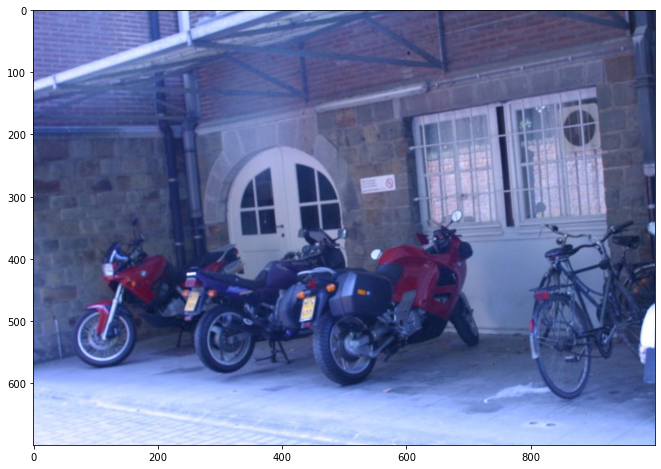

result


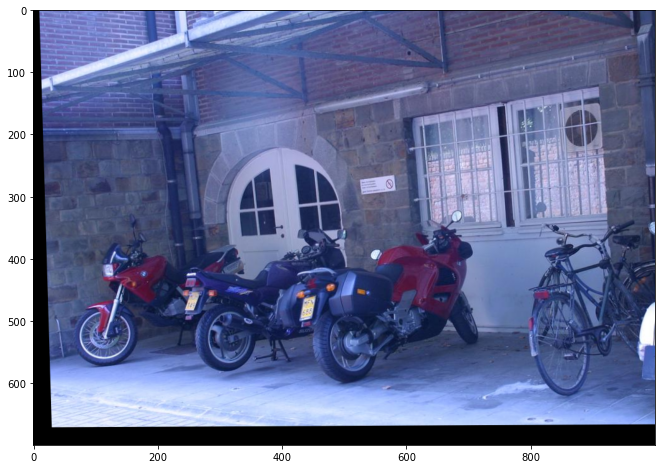

[[ 9.0831059e-01  3.1880093e-01 -2.1210236e+01]
 [-1.6558659e-01  9.5899701e-01  7.3438026e+01]
 [ 4.9169688e-04 -1.0459418e-05  1.0000000e+00]]
target


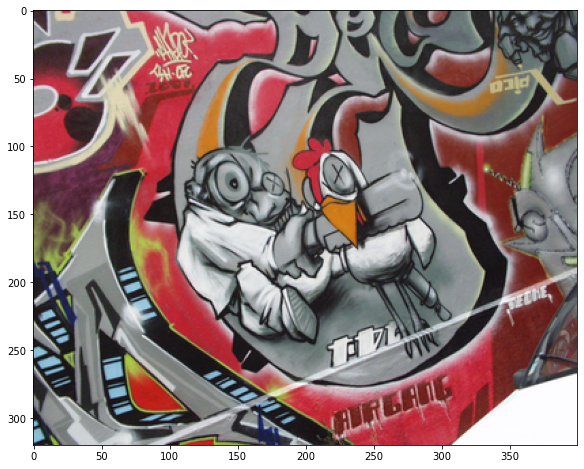

result


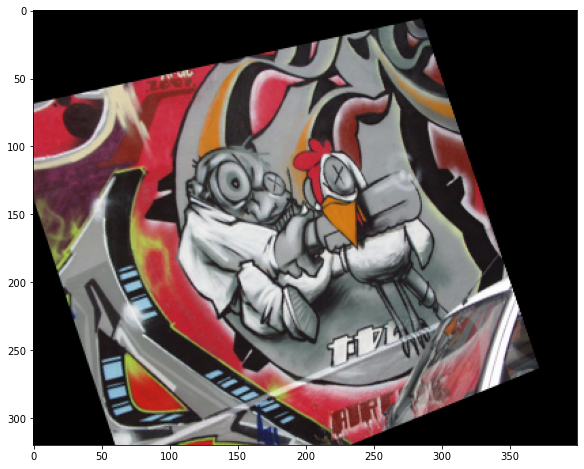

[[ 9.8569113e-01 -1.1707624e-02  7.6737514e+00]
 [ 2.1691804e-03  9.8324859e-01 -1.4700309e+00]
 [-1.3055362e-05 -2.4964453e-05  1.0000000e+00]]
target


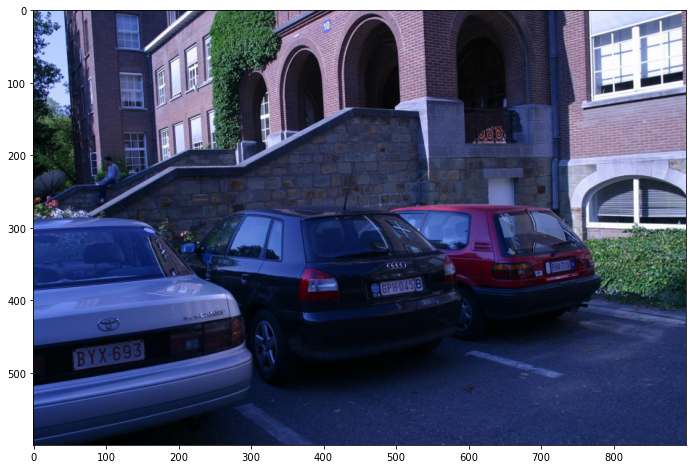

result


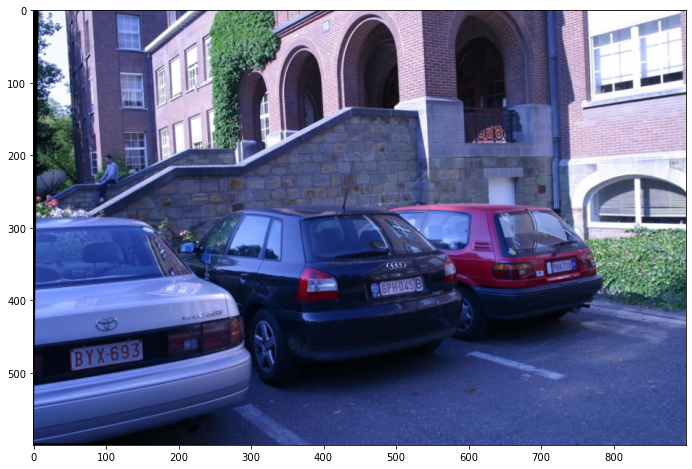

[[ 6.8212706e-01  3.0430263e-02  3.3185658e+01]
 [-4.5436390e-02  9.0751666e-01  5.9497433e+01]
 [-1.7927030e-04  1.3849273e-05  1.0000000e+00]]
target


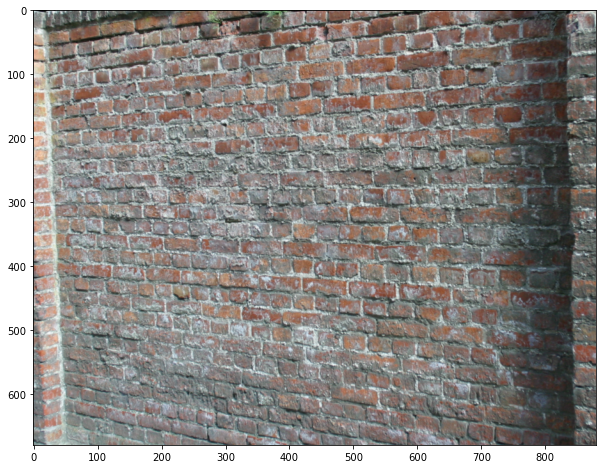

result


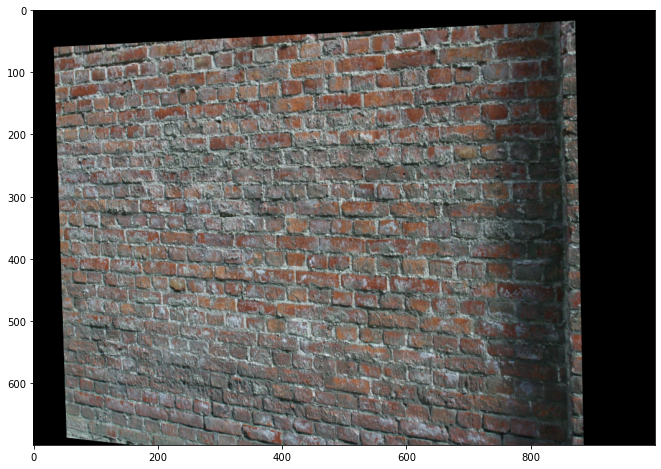

In [4]:
path = './data/'
filenames = ['bikes', 'graf' , 'leuven' , 'wall' ]
#
# change xxx1.png to match xxx2.png
#
#                                   first True: display transformation
#                                 second  True: display pictures
for filename in filenames:
    cal_hoomography_with_RANSAC(path , filename, '1' , '2' ,  True , True)

In [5]:
def get_pixel_contributions(x, y):
    """ Gets the overlapped pixels along with the relative contributions.
          Args:
            x: The x-coordinate
            y: The y-coordinate
          Return:
            pixel_contributions: List of [x, y, contribution] where (x, y) are the coordinates of
                                 pixels that the input overlaps with.
    """
    x_list = [np.floor(x) , np.floor(x)+1]
    y_list = [np.floor(y) , np.floor(y)+1]
    pixel_contributions = []
        
    for tmp_x in x_list:
        for tmp_y in y_list:
            overlapx = 1.0 - np.abs(x-tmp_x)
            overlapy = 1.0 - np.abs(y-tmp_y)
            pixel_contributions.append([int(tmp_x), int(tmp_y), overlapx*overlapy ])
        
    return pixel_contributions

def inverse_warping(transform, path , filename ,source):

    
    image = cv2.imread( path + filename + source + '.png', cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    num = 1
    rows, cols, channels = image.shape
    output_image = np.zeros((rows * num + 40, cols * num +40 , 3), dtype=int)
    transform[0,2] += (num - 1.0) * cols / 2.0 + 20
    transform[1,2] += (num - 1.0) * rows / 2.0 + 20
    transform = np.linalg.inv(transform)
  # Invert the transformation matrix
    

    for i in range(rows*num + 40):
        for j in range(cols*num + 40):

          # Get the resulting pixel coordinate after applying the inverse transformation above for pixel (j, i()
            result = transform @ np.array([[j], [i], [1]])

          # Use interpolation 
            interpolations = get_pixel_contributions(result[0, 0], result[1, 0])

          # Do something similar to forward_warping but with inverse warping
            for k in range(4):
                    x = interpolations[k][0]
                    y = interpolations[k][1]
                    scale = interpolations[k][2]
                    if -1 < x < cols and -1 < y < rows:
                        output_image[i, j, 0] += int(scale * image[y, x, 0])
                        output_image[i, j, 1] += int(scale * image[y, x, 1])
                        output_image[i, j, 2] += int(scale * image[y, x, 2])

    return output_image



In [6]:
def feathering(image1 , image2):

    rows , cols , ch = image1.shape
    #rows , cols , ch = (300,300,3)
    window_cols = np.int( cols * 0.1 )
    one_cols = (cols-window_cols)//2
    zero_cols = cols - one_cols - window_cols
    
    scale_one = np.ones((rows , one_cols,ch), dtype = np.float)
    scale_zero = np.zeros((rows , zero_cols,ch), dtype = np.float)
    
    window1 = np.zeros( (rows , window_cols,ch), dtype = np.float )
    window2 = np.zeros( (rows , window_cols,ch), dtype = np.float )
    
    a = np.linspace( 1, 0 , num = window_cols, dtype = np.float)
    a = a.reshape(-1,1)
    a = np.concatenate((a,a,a),axis=1)
    for i in range(rows):
        window1[i] = a
        
    b = np.linspace( 0, 1 , num = window_cols, dtype = np.float)
    b = b.reshape(-1,1)
    b = np.concatenate((b,b,b),axis=1)
    for i in range(rows):
        window2[i] = b
        
    window1 = np.concatenate((scale_one, window1 , scale_zero),axis=1)
    window2 = np.concatenate((scale_zero, window2 , scale_one),axis=1)
    
    output = (image1 * window1) + (image2 * window2)
    output = np.uint(output)
    return output

In [7]:
def get_panorama(path , filename , blending_style  = 'normal' ,display = False):
# N number of images
# path :where the images locate at
# filename bikes graf etc. 

#if True:
#    path = './data/'
#    filename = filenames[3]
#    N = 3
    filenames = glob(f'{path+filename}*.*')
    N = len(filenames)
    #print(N)
    middle_pic = (1 + N ) //2 
    middle_image = cv2.imread( path + filename + str(middle_pic) + '.png', cv2.IMREAD_COLOR)
    
    # you might need to change '.png'
    
    middle_image = cv2.cvtColor( middle_image , cv2.COLOR_BGR2RGB)
    rows, cols, channels = middle_image.shape
    transformation = np.zeros((N,3,3) , dtype = np.float)
    output_images = []
    
    for i in range(N):
        print("transformation between ",i+1 ,' ',(1 + N ) //2 )
        transformation[i] = cal_hoomography_with_RANSAC(path , filename, str( i+1 ) , str(middle_pic) , True , False)
        result = inverse_warping(transformation[i] , path ,  filename , str(i+1) )
        result = result[0:rows , 0:cols,:]
        #show_pic(result)
        #print(result.shape)
        output_images.append(result)
    #print(len(output_images))
    output_image = np.array(output_images ,np.float)
    panorama = np.amax(output_image, axis = 0)
    panorama = np.uint(panorama)
    
    
    
    if( blending_style == 'feathering'):
        for i in range(N):
            panorama = feathering(panorama,output_image[i])
        panorama = feathering(panorama,output_image[(1 + N ) //2 ])
        
    if(display == True):
        show_pic(panorama)        
    return panorama
    

For TA or CAs : If you need to check the function, remember to change the path

I also expended the boundary by 40 pixels, in inverse warping

transformation between  1   2
[[ 1.0229669e+00  6.5637524e-03  1.7209431e+01]
 [-5.8776122e-03  1.0142541e+00 -2.6300430e+01]
 [ 9.3138224e-06  6.3154107e-06  1.0000000e+00]]
transformation between  2   2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
transformation between  3   2
[[ 1.0105051e+00  6.9435383e-03  1.6182468e+01]
 [ 4.3175835e-03  9.9699509e-01  2.7438989e+00]
 [ 9.4928137e-06 -5.1666880e-06  1.0000000e+00]]


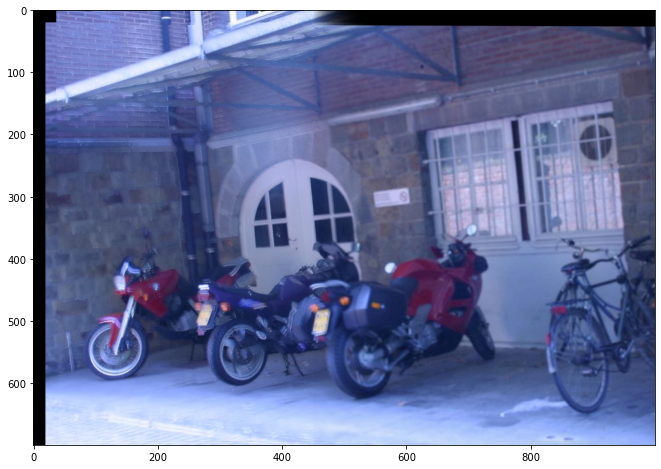

transformation between  1   2
[[ 8.5580266e-01  2.6276112e-01 -1.0247288e+01]
 [-1.6677138e-01  8.8075554e-01  7.8399742e+01]
 [ 4.1588547e-04 -2.0369628e-04  1.0000000e+00]]
transformation between  2   2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
transformation between  3   2
[[ 1.2473121e+00 -5.3092915e-01  3.4836388e+01]
 [-5.4177705e-02  1.0616068e+00 -2.0649250e+00]
 [-5.2250165e-04  3.9215549e-04  1.0000000e+00]]


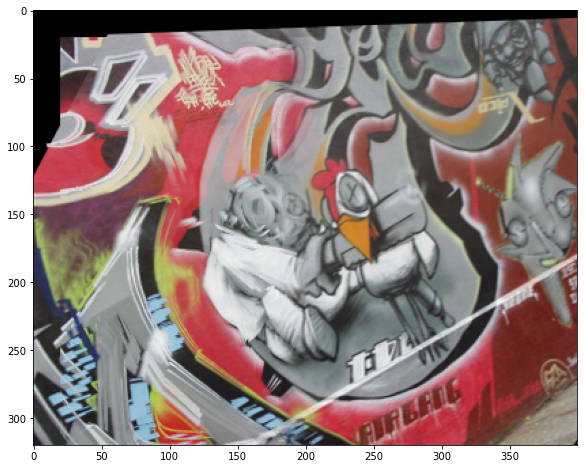

transformation between  1   2
[[ 1.0122666e+00  1.3989906e-03  1.0610005e+00]
 [ 6.1771586e-03  1.0041746e+00 -4.1962867e+00]
 [ 9.3646031e-06  1.4764958e-06  1.0000000e+00]]
transformation between  2   2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
transformation between  3   2
[[ 1.0052929e+00 -9.2936130e-03  8.6365646e-01]
 [ 5.2371402e-03  9.9890459e-01  2.1423678e+00]
 [ 9.6776812e-06 -1.1903404e-05  1.0000000e+00]]


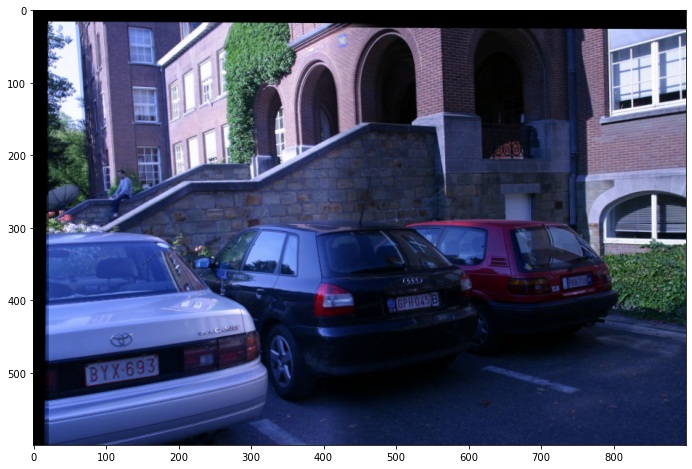

transformation between  1   2
[[ 6.6542590e-01  2.3300407e-02  3.8113163e+01]
 [-4.8150960e-02  8.8619179e-01  6.3705765e+01]
 [-1.9420343e-04  4.7760695e-06  1.0000000e+00]]
transformation between  2   2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
transformation between  3   2
[[-9.2105883e-01  3.2574102e-02  5.6361768e+02]
 [-7.3863012e-01  2.5557747e-02  4.5220392e+02]
 [-1.6351964e-03  5.9685248e-05  1.0000000e+00]]


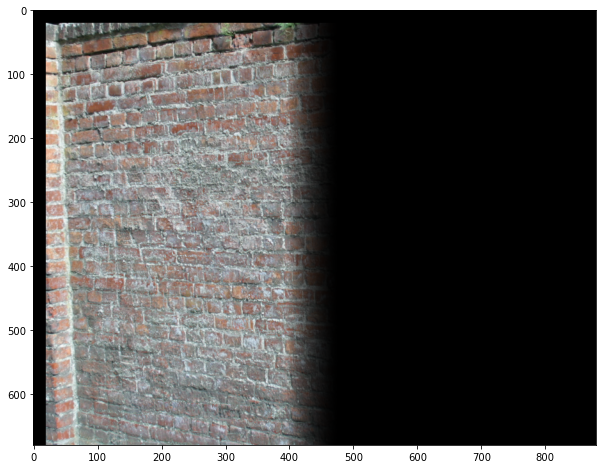

In [8]:
for filename in filenames:
    output_images = get_panorama(path , filename,blending_style  = 'feathering' ,display = True)


In [9]:
def draw_lines(result , shape , xform, color ):
    #print(color)
    cols, rows, channels = shape
    points = np.array( [ [0,0,1],[0,cols,1],[rows,cols,1],[rows,0,1],[0,0,1] ],dtype = np.float )
    points = points.T
    for i in range(4):
        p1 = xform @ points[:,i]
        p2 = xform @ points[:,i+1]
        result = cv2.line(result, (int(p1[0]),int(p1[1])), (int(p2[0]),int(p2[1])), color, 10)
    #show_pic(result)
    return result

In [10]:
def obj_detect( path , filename , test_name , color):    
    #path = './data/'
    object_name =  filename
    img1 = cv2.imread( path + object_name + '1' + '.png', cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor( img1 , cv2.COLOR_BGR2RGB)

    #test_name = 'testexample'
    img2 = cv2.imread( path +  test_name , cv2.IMREAD_COLOR)
    img2 = cv2.cvtColor( img2 , cv2.COLOR_BGR2RGB)

    rows, cols, channels = img1.shape
    output_shape = ( img2.shape[1] , img2.shape[0])
    #path = './data/'
    #filename = 'graf'
    # Some parameters
    num_samples = 4
    num_trials = 1000
    
    inlier_thresh = 5.0

    # To keep track of the best transformation
    xform = np.zeros((3, 3))
    xforms = []
    
    result = img2.copy()
    
    while( True):
        most_inliers = 0
        sift = cv2.SIFT_create()
        kp1, des1 = sift.detectAndCompute(img1,None)
        kp2, des2 = sift.detectAndCompute(img2,None)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        all_matches = flann.knnMatch(des1,des2,k=2)
    
        matches = []
        for m,n in all_matches:
            if m.distance < 0.7*n.distance:
                matches.append(m)
        #total_matches = np.minimum(100,len(matches))
        total_matches = len(matches)
        #print(total_matches)
        # Loop through num_trials times
        for i in range(num_trials):

            # Randomly choose num_samples indices from total number of matches
            choices = np.random.choice(total_matches, min(num_samples,total_matches), replace=False)

            # Get the matching keypoint coordinates from those indices
            keypoints1 = []
            keypoints2 = []
            for choice in choices:
                keypoint1, keypoint2 = get_keypoint_coord_from_match(matches, kp1, kp2, choice)
                keypoints1.append(keypoint1)
                keypoints2.append(keypoint2) 
              # Use getAffineTransform to get our transformation matrix
            keypoints1 = np.float32(keypoints1)
            keypoints2 = np.float32(keypoints2)
            #print(keypoints1.shape)
            M = cal_2d_homography(keypoints1, keypoints2)
            transformation = np.zeros((3,3),dtype = np.float)
            transformation = M.copy()
            num_inliers = 0

              # Loop through all of our matches
            for j in range(total_matches):

                # Get the coordinates of the matching features using get_keypoint_coord_from_match
                point1, point2 = get_keypoint_coord_from_match(matches, kp1, kp2, j)

                # Compute the expected coordinate after transforming the keypoint from img1
                # using the computed affine transformation
                p1 = np.array([point1[0],point1[1],1.0])
                exp_coord =  transformation @ p1
                exp_coord = exp_coord/exp_coord[2]
                dif = np.linalg.norm(exp_coord[0:2] - point2 )
                if inlier_thresh > dif:
                    num_inliers = num_inliers+1

              # If for this transformation we have found the most inliers update most_inliers and xform
            if (num_inliers > most_inliers and num_inliers >= 50):
                most_inliers = num_inliers
                xform = np.copy(np.float32(transformation))
        if(most_inliers < 50):
            break
        output = cv2.warpPerspective(img1, xform, output_shape[0:2])
        img2[ output !=0 ] = 0
        xforms.append(xform)
        result = draw_lines(result , img1.shape  , xform , color )
        #pos = np.where( output !=0 )
        #pos = np.array(pos)
        #print(pos.shape)
        #output = img2 -output
        #show_pic(img2)
        #img2 = output
        
    return result, len(xforms)


For TA or CAs : If you need to check the function, remember to change the path

bikes
number:  1


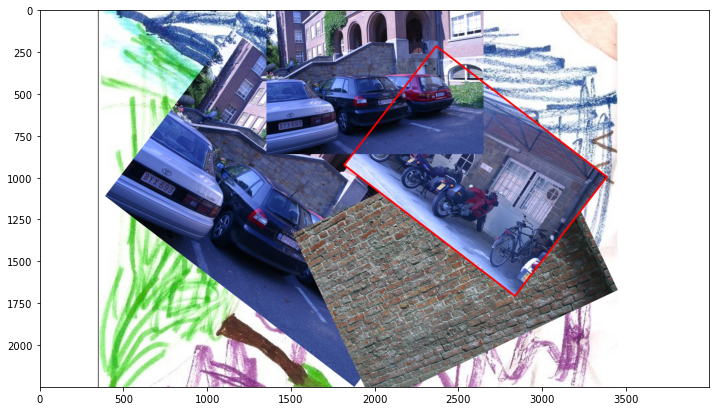

graf
number:  0


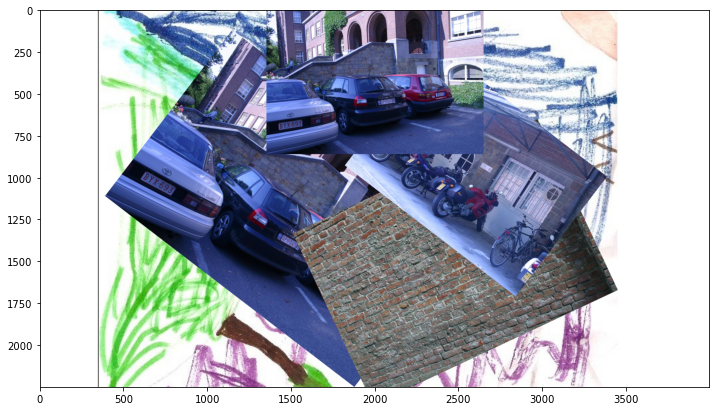

leuven
number:  2


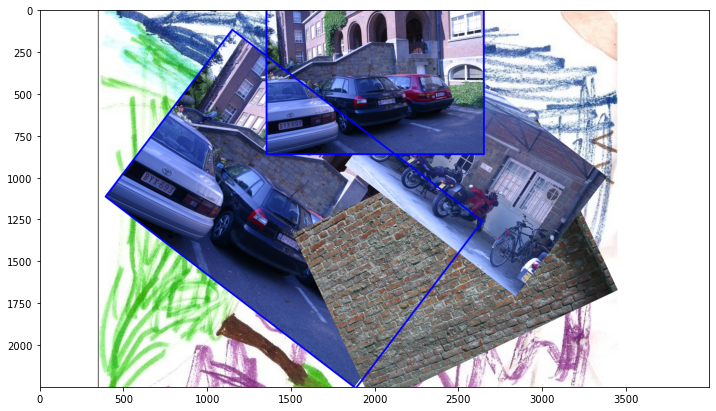

wall
number:  1


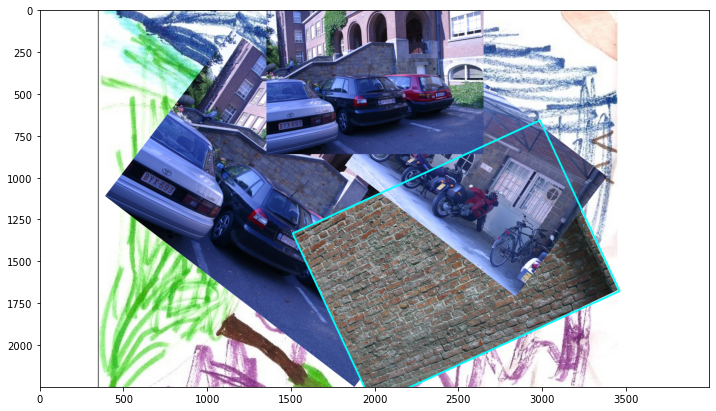

In [11]:
path = './data/'
filenames = ['bikes', 'graf' , 'leuven' , 'wall' ]
#
# change xxx1.png to match xxx2.png
#

#setting colors
colors = [ [255,0,0],[0,255,0],[0,0,255],[0,255,255],[255,0,255],[255,255,0] ]
test_file = "testexample.jpg"
for i in range(len(filenames)):
    output , numbers = obj_detect(path , filenames[i], test_file ,  colors[i])
    print(filenames[i])
    print("number: ", numbers)
    show_pic(output)